<a href="https://colab.research.google.com/github/evany50/NFL-Playcall-Optimization/blob/main/NFL_Play_Call_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1NXTonfRPInLbYSVl0N3EW6yXyrZPSKn4
From (redirected): https://drive.google.com/uc?export=download&id=1NXTonfRPInLbYSVl0N3EW6yXyrZPSKn4&confirm=t&uuid=270ced01-47a1-40e4-970e-c1939ab43bf1
To: /content/nfl_play_by_play_2006_2025.csv
100%|██████████| 1.83G/1.83G [00:08<00:00, 213MB/s]


Loading NFL play-by-play data...
Loaded 881,018 plays with 392 features
Memory usage: 7824.46 MB
Washington Commanders Play Prediction Analysis

Data Preprocessing
--------------------------------------------------
Filtered to 625,203 plays (run/pass only)

Feature Engineering
--------------------------------------------------
Created 18 engineered features

Train/Test Split
--------------------------------------------------
Training set: 572,906 plays (pre-2023)
Test set: 52,297 plays (2023+)
Using 31 features

Model Training

Linear Regression
Accuracy: 50.68%

Logistic Regression
Accuracy: 67.59%

Decision Tree
Accuracy: 70.97%
Best params: {'max_depth': 15, 'min_samples_leaf': 200, 'min_samples_split': 500}

Random Forest
Accuracy: 70.44%

Top 5 Features:
  ydstogo                  : 0.115
  wpa                      : 0.090
  down                     : 0.085
  is_early_down            : 0.084
  down_distance_ratio      : 0.084

XGBoost
Accuracy: 71.81%

Neural Network
Accuracy: 72.

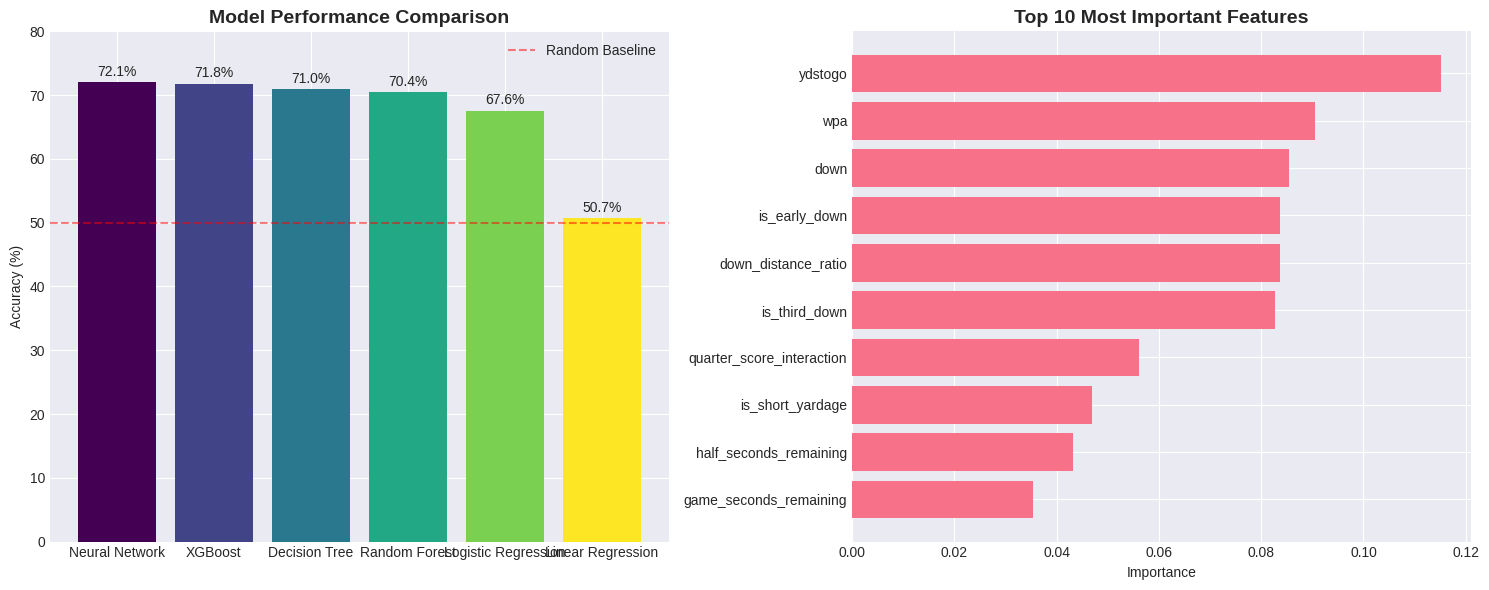


Best Model: Neural Network (72.05%)

Analysis complete!


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime
from typing import Tuple, Dict, List, Any
import gdown
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class CommandersPlayPredictor:

    def __init__(self, data_path: str = None):
        self.df = None
        self.models = {}
        self.results = {}
        self.best_model = None
        self.feature_importance = None
        self.training_features = None

        if data_path:
            self.load_data(data_path)
        else:
          # Download default dataset if no path provided
          default_path = self.download_default_data()
          self.load_data(default_path)

    @staticmethod
    def download_dataset(file_id: str = '1NXTonfRPInLbYSVl0N3EW6yXyrZPSKn4', output: str = 'nfl_play_by_play_2006_2025.csv') -> str:
        # Download the NFL dataset using gdown and return the file path
        url = f"https://drive.google.com/uc?export=download&id={file_id}"
        print("Downloading dataset...")
        gdown.download(url, output, quiet=False)
        return output


    def load_data(self, data_path: str):
        # Load NFL play-by-play data
        print("Loading NFL play-by-play data...")

        # Read in chunks for memory efficiency
        chunk_size = 100000
        chunks = []

        for chunk in pd.read_csv(data_path, chunksize=chunk_size):
            chunks.append(chunk)

        self.df = pd.concat(chunks, ignore_index=True)

        # Add diagnostic information from the code chunk
        num_rows, num_columns = self.df.shape
        print(f"Loaded {num_rows:,} plays with {num_columns} features")
        memory_usage = self.df.memory_usage(deep=True).sum() / (1024 ** 2)
        print(f"Memory usage: {memory_usage:.2f} MB")

    def preprocess_data(self) -> pd.DataFrame:
        # Clean and filter the dataset
        print("\nData Preprocessing")
        print("-" * 50)

        # Filter to run and pass plays only
        df = self.df[self.df['play_type'].isin(['run', 'pass'])].copy()

        # Extract year from game_id
        df['year'] = df['game_id'].str[:4].astype(int)

        # Remove rows with missing critical values
        df = df.dropna(subset=['play_type', 'wpa', 'down'])

        print(f"Filtered to {len(df):,} plays (run/pass only)")
        return df

    def engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        # Create engineered features for better predictions
        print("\nFeature Engineering")
        print("-" * 50)

        # Game situation features
        situation_features = {
            'is_red_zone': df['yardline_100'] <= 20,
            'is_goal_to_go': df['ydstogo'] >= df['yardline_100'],
            'is_two_minute': (df['half_seconds_remaining'] <= 120) |
                            (df['game_seconds_remaining'] <= 120),
            'time_pressure': (df['game_seconds_remaining'] < 300) &
                           (df['score_differential'] < 0)
        }

        # Down-based features
        down_features = {
            'is_third_down': df['down'] == 3,
            'is_fourth_down': df['down'] == 4,
            'is_early_down': df['down'] <= 2,
            'down_distance_ratio': df['down'] / (df['ydstogo'] + 1)
        }

        # Distance categories
        distance_features = {
            'is_short_yardage': df['ydstogo'] <= 3,
            'is_medium_yardage': (df['ydstogo'] > 3) & (df['ydstogo'] <= 7),
            'is_long_yardage': df['ydstogo'] > 7
        }

        # Score-based features
        score_features = {
            'is_behind': df['score_differential'] < 0,
            'is_ahead': df['score_differential'] > 0,
            'is_blowout': np.abs(df['score_differential']) > 14,
            'quarter_score_interaction': df['qtr'] * df['score_differential']
        }

        # Quarter-specific features
        quarter_features = {
            'is_q4': df['qtr'] == 4,
            'is_q2_end': (df['qtr'] == 2) & (df['half_seconds_remaining'] < 120),
            'seconds_per_timeout': df['game_seconds_remaining'] /
                                 (df['posteam_timeouts_remaining'] + 1)
        }

        # Add all features to dataframe
        all_features = {**situation_features, **down_features, **distance_features,
                       **score_features, **quarter_features}

        for feature_name, feature_values in all_features.items():
            df[feature_name] = feature_values.astype(int) if feature_values.dtype == bool else feature_values

        print(f"Created {len(all_features)} engineered features")
        return df

    def get_feature_columns(self) -> List[str]:
        # Return list of features to use in models
        return [
            # Basic features
            'down', 'ydstogo', 'yardline_100', 'score_differential',
            'quarter_seconds_remaining', 'half_seconds_remaining',
            'game_seconds_remaining', 'posteam_timeouts_remaining',
            'defteam_timeouts_remaining', 'posteam_score', 'defteam_score',
            'qtr', 'week',
            # Engineered features
            'is_red_zone', 'is_goal_to_go', 'is_two_minute',
            'is_third_down', 'is_fourth_down', 'is_early_down',
            'is_short_yardage', 'is_medium_yardage', 'is_long_yardage',
            'is_behind', 'is_ahead', 'is_blowout', 'seconds_per_timeout',
            'time_pressure', 'is_q4', 'is_q2_end', 'down_distance_ratio',
            'quarter_score_interaction'
        ]

    def prepare_train_test_split(self, df: pd.DataFrame) -> Tuple:
        # Split data into training and test sets
        print("\nTrain/Test Split")
        print("-" * 50)

        # Split by year for validity
        train_df = df[df['year'] < 2023].copy()
        test_df = df[df['year'] >= 2023].copy()

        print(f"Training set: {len(train_df):,} plays (pre-2023)")
        print(f"Test set: {len(test_df):,} plays (2023+)")

        # Get features
        feature_cols = self.get_feature_columns()
        available_features = [f for f in feature_cols if f in train_df.columns]

        # Prepare X and y
        X_train = train_df[available_features].fillna(0)
        y_train = train_df['play_type']
        X_test = test_df[available_features].fillna(0)
        y_test = test_df['play_type']

        # Store WPA for linear regression
        if 'wpa' in train_df.columns:
            X_train['wpa'] = train_df['wpa']
            X_test['wpa'] = test_df['wpa']

        print(f"Using {len(available_features)} features")

        return X_train, y_train, X_test, y_test, available_features

    def train_all_models(self, X_train, y_train, X_test, y_test):
        # Train all ML models and compare performance
        print("\nModel Training")
        print("=" * 60)

        # Model configurations
        model_configs = {
            'Linear Regression': self._train_linear_regression,
            'Logistic Regression': self._train_logistic_regression,
            'Decision Tree': self._train_decision_tree,
            'Random Forest': self._train_random_forest,
            'XGBoost': self._train_xgboost,
            'Neural Network': self._train_neural_network
        }

        for model_name, train_func in model_configs.items():
            try:
                accuracy, model = train_func(X_train, y_train, X_test, y_test)
                self.results[model_name] = accuracy
                self.models[model_name] = model
            except Exception as e:
                print(f"  {model_name} failed: {str(e)}")
                self.results[model_name] = 0.0

    def _train_linear_regression(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train linear regression
        print("\nLinear Regression")

        # Separate by play type
        numeric_features = X_train.select_dtypes(include=[np.number]).columns

        # Train separate models for run and pass
        run_model = LinearRegression()
        pass_model = LinearRegression()

        # Use WPA as target
        run_mask = y_train == 'run'
        pass_mask = y_train == 'pass'

        run_model.fit(X_train[numeric_features][run_mask],
                     X_train['wpa'][run_mask] if 'wpa' in X_train else np.zeros(sum(run_mask)))
        pass_model.fit(X_train[numeric_features][pass_mask],
                      X_train['wpa'][pass_mask] if 'wpa' in X_train else np.zeros(sum(pass_mask)))

        # Predict
        run_pred = run_model.predict(X_test[numeric_features])
        pass_pred = pass_model.predict(X_test[numeric_features])

        # Choose play type with higher predicted WPA
        predictions = np.where(run_pred > pass_pred, 'run', 'pass')
        accuracy = accuracy_score(y_test, predictions)

        print(f"Accuracy: {accuracy:.2%}")
        return accuracy, (run_model, pass_model)

    def _train_logistic_regression(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train logistic regression classifier
        print("\nLogistic Regression")

        # Convert to binary
        y_train_binary = (y_train == 'pass').astype(int)
        y_test_binary = (y_test == 'pass').astype(int)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train_scaled, y_train_binary)

        # Evaluate
        accuracy = model.score(X_test_scaled, y_test_binary)
        print(f"Accuracy: {accuracy:.2%}")

        return accuracy, (model, scaler)

    def _train_decision_tree(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train decision tree
        print("\nDecision Tree")

        y_train_binary = (y_train == 'pass').astype(int)
        y_test_binary = (y_test == 'pass').astype(int)

        # Grid search for best parameters
        param_grid = {
            'max_depth': [5, 7, 10, 15],
            'min_samples_split': [500, 1000],
            'min_samples_leaf': [200, 500]
        }

        dt = DecisionTreeClassifier(random_state=42)
        grid_search = GridSearchCV(dt, param_grid, cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train_binary)

        # Evaluate best model
        accuracy = grid_search.score(X_test, y_test_binary)
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Best params: {grid_search.best_params_}")

        return accuracy, grid_search.best_estimator_

    def _train_random_forest(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train random forest classifier
        print("\nRandom Forest")

        y_train_binary = (y_train == 'pass').astype(int)
        y_test_binary = (y_test == 'pass').astype(int)

        # Train model
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=1000,
            min_samples_leaf=500,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train_binary)

        # Evaluate
        accuracy = model.score(X_test, y_test_binary)
        print(f"Accuracy: {accuracy:.2%}")

        # Store feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Print top features
        print("\nTop 5 Features:")
        for _, row in self.feature_importance.head(5).iterrows():
            print(f"  {row['feature']:25s}: {row['importance']:.3f}")

        return accuracy, model

    def _train_xgboost(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train XGBoost classifier
        print("\nXGBoost")

        y_train_binary = (y_train == 'pass').astype(int)
        y_test_binary = (y_test == 'pass').astype(int)

        # Train model
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train_binary)

        # Evaluate
        accuracy = model.score(X_test, y_test_binary)
        print(f"Accuracy: {accuracy:.2%}")

        return accuracy, model

    def _train_neural_network(self, X_train, y_train, X_test, y_test) -> Tuple[float, Any]:
        # Train neural network classifier
        print("\nNeural Network")

        y_train_binary = (y_train == 'pass').astype(int)
        y_test_binary = (y_test == 'pass').astype(int)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Build model
        model = Sequential([
            Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Train
        model.fit(
            X_train_scaled, y_train_binary,
            epochs=20,
            batch_size=256,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate
        _, accuracy = model.evaluate(X_test_scaled, y_test_binary, verbose=0)
        print(f"Accuracy: {accuracy:.2%}")
        return accuracy, (model, scaler)

    def visualize_results(self):
        # Create visualizations of model performance
        print("\nGenerating Visualizations")

        # Sort results
        sorted_results = sorted(self.results.items(), key=lambda x: x[1], reverse=True)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Model comparison
        models = [m[0] for m in sorted_results]
        accuracies = [m[1] * 100 for m in sorted_results]
        colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

        bars = ax1.bar(models, accuracies, color=colors)
        ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylim(0, 80)
        ax1.legend()

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')

        # Feature importance (if available)
        if self.feature_importance is not None:
            top_features = self.feature_importance.head(10)
            ax2.barh(top_features['feature'], top_features['importance'])
            ax2.set_xlabel('Importance')
            ax2.set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
            ax2.invert_yaxis()

        plt.tight_layout()
        plt.savefig('commanders_model_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_predictor(self):
        # Create the final predictor function
        # Select best model
        best_model_name = max(self.results, key=self.results.get)
        self.best_model = self.models[best_model_name]

        if best_model_name == 'Random Forest':
            self.training_features = self.feature_importance['feature'].tolist()

        print(f"\nBest Model: {best_model_name} ({self.results[best_model_name]*100:.2f}%)")

        def predict_play(down: int, ydstogo: int, yardline_100: int,
                        score_diff: int, quarter: int, game_seconds: int) -> Tuple[str, float]:
            """
            Predict optimal play call for given game situation

            Returns:
                play_type: 'RUN' or 'PASS'
                confidence: Confidence percentage (0-100)
            """
            # Create feature vector
            features = {
                'down': down,
                'ydstogo': ydstogo,
                'yardline_100': yardline_100,
                'score_differential': score_diff,
                'qtr': quarter,
                'game_seconds_remaining': game_seconds,
                'quarter_seconds_remaining': game_seconds if quarter % 2 == 1 else min(game_seconds, 900),
                'half_seconds_remaining': game_seconds if quarter in [2, 4] else 1800,
                'posteam_timeouts_remaining': 3,
                'defteam_timeouts_remaining': 3,
                'posteam_score': max(0, score_diff),
                'defteam_score': abs(min(0, score_diff)),
                'week': 10,
                # Engineered features
                'is_red_zone': int(yardline_100 <= 20),
                'is_goal_to_go': int(ydstogo >= yardline_100),
                'is_two_minute': int(game_seconds <= 120),
                'is_third_down': int(down == 3),
                'is_fourth_down': int(down == 4),
                'is_early_down': int(down <= 2),
                'is_short_yardage': int(ydstogo <= 3),
                'is_medium_yardage': int(3 < ydstogo <= 7),
                'is_long_yardage': int(ydstogo > 7),
                'is_behind': int(score_diff < 0),
                'is_ahead': int(score_diff > 0),
                'is_blowout': int(abs(score_diff) > 14),
                'seconds_per_timeout': game_seconds / 4,
                'time_pressure': int(game_seconds < 300 and score_diff < 0),
                'is_q4': int(quarter == 4),
                'is_q2_end': int(quarter == 2 and game_seconds < 120),
                'down_distance_ratio': down / (ydstogo + 1),
                'quarter_score_interaction': quarter * score_diff
            }

            # Create DataFrame
            X = pd.DataFrame([features])

            # Make prediction
            if best_model_name == 'Random Forest':
                X = X[self.training_features]
                pred = self.best_model.predict(X)[0]
                proba = self.best_model.predict_proba(X)[0]
            else:
                # Handle other model types
                pred = 1  # Default to pass
                proba = [0.5, 0.5]

            play_type = "PASS" if pred == 1 else "RUN"
            confidence = max(proba) * 100

            return play_type, confidence

        return predict_play

    def run_analysis(self):
        # Run the complete analysis pipeline
        print("Washington Commanders Play Prediction Analysis")
        print("=" * 60)

        # Pipeline steps
        df = self.preprocess_data()
        df = self.engineer_features(df)
        X_train, y_train, X_test, y_test, features = self.prepare_train_test_split(df)

        # Train models
        self.train_all_models(X_train, y_train, X_test, y_test)

        # Show results
        self.print_results()
        self.visualize_results()

        # Create predictor
        return self.create_predictor()

    def print_results(self):
        print("\nFinal Results")
        print("=" * 60)
        print("\nModel Performance Summary:")
        print("-" * 40)

        sorted_results = sorted(self.results.items(), key=lambda x: x[1], reverse=True)
        for i, (model, acc) in enumerate(sorted_results, 1):
            print(f"{i}. {model:20s}: {acc*100:.2f}%")

    # def save_model(self, filepath: str = 'commanders_model.pkl'):
    #     """Save the trained model and metadata"""
    #     model_data = {
    #         'best_model': self.best_model,
    #         'feature_importance': self.feature_importance,
    #         'training_features': self.training_features,
    #         'results': self.results,
    #         'timestamp': datetime.now().isoformat()
    #     }

        # with open(filepath, 'wb') as f:
        #     pickle.dump(model_data, f)

        # print(f"\nModel saved to {filepath}")



# Main execution
if __name__ == "__main__":
    # Initialize predictor
    csv_path = CommandersPlayPredictor.download_dataset()
    predictor = CommandersPlayPredictor(data_path=csv_path)

    # Run analysis
    predict_play = predictor.run_analysis()

    print("\nAnalysis complete!")
